# Which Classifier is Should I Choose? 

This is one of the most import questions to ask when approaching a machine learning problem. I find it easier to just test them all at once. Here's 10 of your favorite Scikit-Learn algorithms applied to the leaf data. 

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#def warn(*args, **kwargs): pass
#import warnings
#warnings.warn = warn

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Preparation


In [6]:
# Swiss army knife function to organize the data

def encode(train, test):
    le = LabelEncoder().fit(train.species) 
    labels = le.transform(train.species)           # encode species strings
    classes = list(le.classes_)                    # save column names for submission
    test_ids = test.id                             # save test ids for submission
    
    train = train.drop(['species', 'id'], axis=1)  
    test = test.drop(['id'], axis=1)
    
    return train, labels, test, test_ids, classes

train, labels, test, test_ids, classes = encode(train, test)
train.head(1)

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.0,0.00293,0.00293,0.035156,0.0,0.0,0.004883,0.0,0.025391


## Stratified Train/Test Split

Stratification is necessary for this dataset because there is a relatively large number of classes (100 classes for 990 samples). This will ensure we have all classes represented in both the train and test indices. 

In [60]:
sss = StratifiedShuffleSplit(labels, test_size=0.2)

for train_index, test_index in sss:
    X_train, X_test = train.values[train_index], train.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

(array([ 100.,  100.,  100.,  100.,   90.,  100.,  100.,  100.,  100.,  100.]),
 array([  0. ,   9.8,  19.6,  29.4,  39.2,  49. ,  58.8,  68.6,  78.4,
         88.2,  98. ]),
 <a list of 10 Patch objects>)

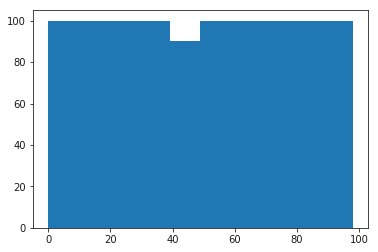

In [34]:
plt.hist(labels)

(array([ 80.,  80.,  80.,  80.,  72.,  80.,  80.,  80.,  80.,  80.]),
 array([  0. ,   9.8,  19.6,  29.4,  39.2,  49. ,  58.8,  68.6,  78.4,
         88.2,  98. ]),
 <a list of 10 Patch objects>)

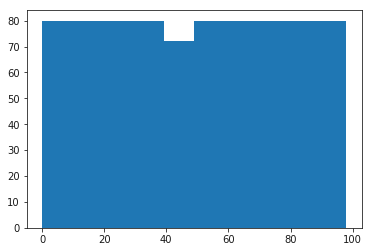

In [35]:
plt.hist(y_train)

## Sklearn Classifier Showdown

Simply looping through 10 out-of-the box classifiers and printing the results. Obviously, these will perform much better after tuning their hyperparameters, but this gives you a decent ballpark idea. 

In [65]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    DecisionTreeClassifier(),
    #RandomForestClassifier(),
    #AdaBoostClassifier(),
    #GradientBoostingClassifier(),
    GaussianNB(),
    #LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis()
    ]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)


KNeighborsClassifier
****Results****
Accuracy: 88.8889%
Log Loss: 1.58607818256
DecisionTreeClassifier
****Results****
Accuracy: 65.1515%
Log Loss: 12.0362402588
GaussianNB
****Results****
Accuracy: 47.9798%
Log Loss: 17.9671412559


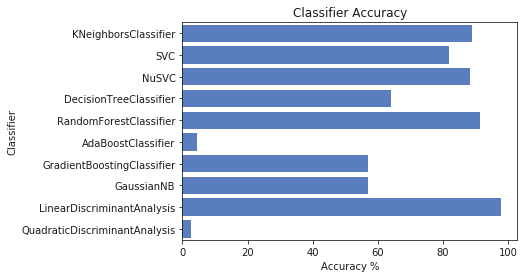

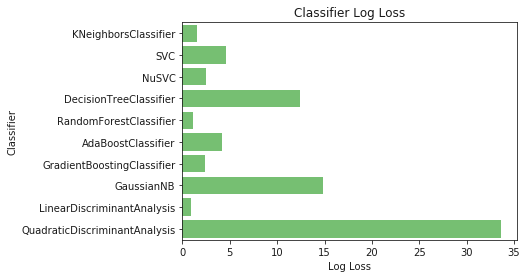

In [9]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors':[3,5,10], 'weights':['uniform','distance']}
clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
clf.fit(X_train, y_train)
print clf.best_params_
print clf.best_score_

{'n_neighbors': 3, 'weights': 'distance'}
0.872474747475


In [80]:
new_clf = KNeighborsClassifier(n_neighbors=3, weights='distance')
new_clf.fit(X_train, y_train)
print new_clf.score(X_test,y_test)*100

90.9090909091


- criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
- max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
- class_weight=None, presort=False

In [75]:
clf = DecisionTreeClassifier().fit(X_train,y_train)
features = clf.feature_importances_
#np.argsort(features)
most_import = np.argsort(features)[:128]
new_X_train = X_train[:, most_import]
new_X_test = X_test[:, most_import]


In [79]:
for clf in classifiers:
    #new_clf = KNeighborsClassifier(n_neighbors=3, weights='distance')
    #new_clf.fit(new_X_train, y_train)
    #print new_clf.score(new_X_test,y_test)*100
    clf.fit(new_X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(new_X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(new_X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))

KNeighborsClassifier
****Results****
Accuracy: 84.3434%
Log Loss: 2.33436302708
DecisionTreeClassifier
****Results****
Accuracy: 66.1616%
Log Loss: 11.6873637296
GaussianNB
****Results****
Accuracy: 64.6465%
Log Loss: 12.1081550936


In [ ]:
parameters = {'criterion':['gini','entropy'], 'weights':['uniform','distance']}